# Normalization for Balancing Loss and Regularization term

<script id="MathJax-script" async
  src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js">
</script>

## Discussion

Loss function to optimize

$$
\mathcal{L}({x},\theta) = \frac{1}{T} \sum_{t=0}^{T}\frac{1}{2}\exp(-\hat{s}_t) ({x}_t - \hat{{x}}_t)^2 + \frac{1}{2}\hat{s}_t
$$

with $[\hat{x}_t, \hat{s}_t] = f_\theta(x_{t-1},x_{t-2},x_{t-3},\dots)$ and $\hat{s}_t = log(\hat{\sigma}^2)$

From the loss function, we see two terms: the MSE term scaled by the variance $\frac{1}{\sigma^2}({x}_t - \hat{{x}}_t)^2$ and the regularization term $\hat{s}_t = \log(\sigma^2)$. If we assume, $x_t$ has a unit \eg meter $[\text{m}]$, the variance will be in $[\text{m}]$ as well. Now, if we consider this unit in $x$ and $\sigma$ in above equation we see that the variance-scaled mean squared error term will be unitless $\frac{({x}_t - \hat{{x}}_t)^2[m^2]}{\sigma^2[m^2]}$. The regularization term, however, has unit $[\log(\text{m})]$, since $\log(\sigma^2)[\log(\text{m})] = 2\log(\sigma)[\log(\text{m})]$. We we arbitrarily change the unit of the data from $1[\text{m}]=100[\text{cm}]$, the regularization term will have a $\log(100)$ times larger value which disturbs the $\frac{1}{2}:\frac{1}{2}$ balance of \cref{eq:loss}.
A normalization of the data makes makes the measured $x$ unitless and aleviates this imbalance problem.
However, the way how we normalize the data matters and indirectly determines the estimated aleatoric uncertainty.
For instance, if we normalize by $3\sigma_\text{dataset}$ instead of $1\sigma_\text{dataset}$, the values of $x$ will be squashed and the regularization term will get more weight over the mse term which may lead to smaller variances relative to the data.

## Takeaway: The scale of the data has an effect on the evaluated aleatoric uncertainty 

### Notebook Structure

0. Setup
1. Exp1: Model trained with normal z-normalization with $ 1\sigma $
2. Exp2: Model trained with normal z-normalization with $ 3\sigma $ <- smaller aleatoric uncertainty
3. Exp3: Model trained with normal z-normalization with $ \frac{1}{2}\sigma $ <- larger aleatoric uncertainty

We train the recurrent network for 5 epochs on the data with different normalizations and visualize the uncertainties on a single text example time series. For plotting, we project the data back to the original value range.

In [ ]:
%%bash
if [ ! -d "/tmp/models" ]; then
  wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz
  tar -xzf /tmp/models.tar.gz -C /tmp --keep-new-files
fi

In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 128
region = "germany"
epochs = 5
include_time = True

# Plotting
idx = 12
N_seen_points = 220#455
N_predictions = 10

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(normalize_sigma_factor=1,znormalize=True):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device).train()

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=znormalize,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,'2010-01-01'),
                            dataset_normalizing_factor=normalize_sigma_factor)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=znormalize,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           dataset_normalizing_factor=normalize_sigma_factor)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=znormalize,
                                augment=False,
                                include_time=include_time,
                                dataset_normalizing_factor=normalize_sigma_factor)

    dataloader = torch.utils.data.DataLoader(dataset,batch_size=512,shuffle=True)
    validdataloader = torch.utils.data.DataLoader(validdataset,batch_size=512,shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

def train(epochs, model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer):

    stats=list()
    for epoch in range(epochs):
        trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
        testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
        metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
        print(f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}")

        stat = dict()
        stat["epoch"] = epoch
        for name, metric in testmetrics.items():
            stat[name]=metric.compute()

        stat["trainloss"] = trainloss.cpu().detach().numpy()
        stat["testloss"] = testloss.cpu().detach().numpy()
        stats.append(stat)

    df = pd.DataFrame(stats)

    if False:
        fig,ax = plt.subplots()
        ax.plot(df.epoch, df.trainloss, label="trainloss")
        ax.plot(df.epoch, df.testloss, label="testloss")
        ax.legend()
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
    return model

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Experiment 1: regular z-normalization

We train a neural network model on data with regular 
z-normalization $ x = \frac{x - \mu}{\sigma} $ (used in the paper)

The mean $\mu$ and standard deviation $\sigma$ are obtained over all examples *and* times of the respective dataset



germany.csv: 0.00B [00:00, ?B/s]

No Dataset found at /tmp/germany.csv. Downloading from https://syncandshare.lrz.de/dl/fiSyp278PifiEghWNsnpH161/germany.csv


germany.csv: 50.4MB [00:04, 10.9MB/s]                            


no cached dataset found at /tmp/germany.npz. partitioning data in train/valid/test 0.6/0.2/0.2 caching csv to npz files for faster loading
loading csv from /tmp/germany.csv
convert string values to numeric
write geometry object from string geojson
add feature id for each unique point
add date column from system:index


100%|██████████| 1000/1000 [00:03<00:00, 316.22it/s]


loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.20, test loss 0.17, mae=0.59, mse=0.57, rmse=0.75



epoch 1: train loss 0.17, test loss 0.16, mae=0.59, mse=0.56, rmse=0.75



epoch 2: train loss 0.15, test loss 0.16, mae=0.58, mse=0.56, rmse=0.75



epoch 3: train loss 0.14, test loss 0.15, mae=0.58, mse=0.56, rmse=0.75



epoch 4: train loss 0.12, test loss 0.15, mae=0.58, mse=0.55, rmse=0.74


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dd1d40320>,
       dtype=object))

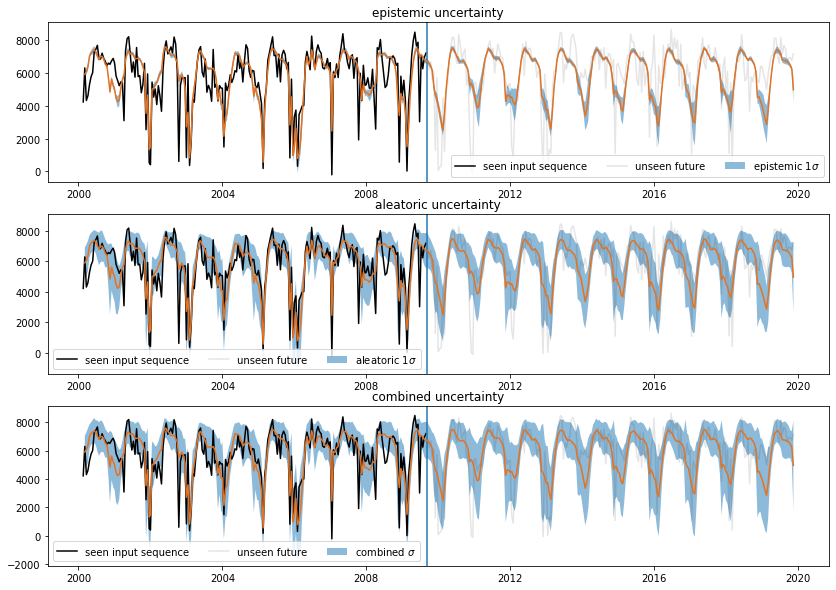

In [2]:
normalize_sigma_factor=1

model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(normalize_sigma_factor)

model = train(epochs, model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer)
    
x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(testdataset.mean,testdataset.std), store=None)

# Experiment 2: Sigma scaled by factor 3

We train a neural network model on data with regular 
z-normalization $ x = \frac{x - \mu}{3\sigma} $

This squashes the values of the data and leads to smaller evaluated aleatoric uncertainties when scaled back to the original domain

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss -0.81, test loss -0.89, mae=0.20, mse=0.06, rmse=0.25



epoch 1: train loss -0.89, test loss -0.90, mae=0.20, mse=0.06, rmse=0.25



epoch 2: train loss -0.90, test loss -0.91, mae=0.20, mse=0.06, rmse=0.25



epoch 3: train loss -0.91, test loss -0.92, mae=0.20, mse=0.06, rmse=0.25



epoch 4: train loss -0.92, test loss -0.92, mae=0.20, mse=0.06, rmse=0.25


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dc3e6da90>,
       dtype=object))

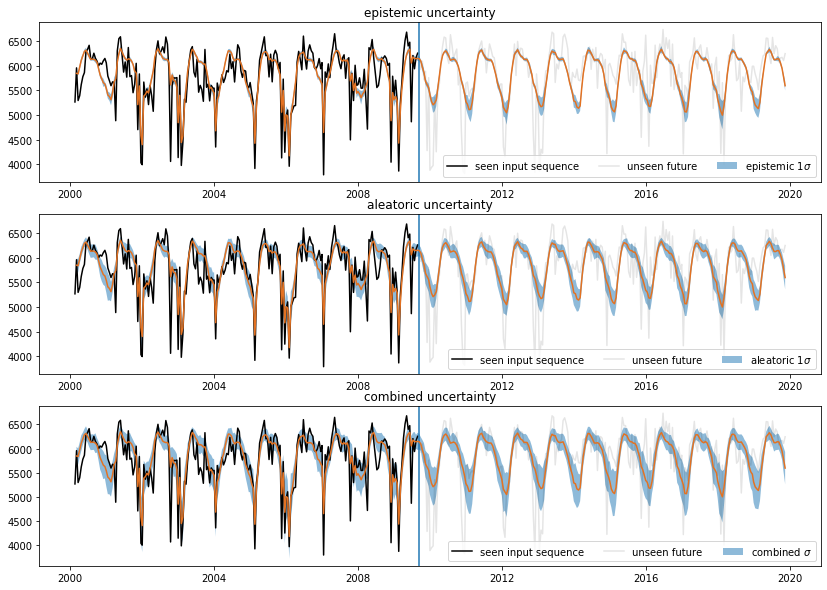

In [3]:
normalize_sigma_factor=3

model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(normalize_sigma_factor)

model = train(epochs, model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer)
    
x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(testdataset.mean,testdataset.std), store=None)

# Experiment 3: Sigma scaled by factor 0.5

We train a neural network model on data with regular 
z-normalization $ x = \frac{x - \mu}{0.5\sigma} $

This squashes the values of the data and leads to smaller evaluated aleatoric uncertainties when scaled back to the original domain

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.92, test loss 0.87, mae=1.18, mse=2.29, rmse=1.51



epoch 1: train loss 0.87, test loss 0.86, mae=1.17, mse=2.26, rmse=1.50



epoch 2: train loss 0.86, test loss 0.85, mae=1.17, mse=2.25, rmse=1.50



epoch 3: train loss 0.85, test loss 0.85, mae=1.17, mse=2.24, rmse=1.50



epoch 4: train loss 0.84, test loss 0.85, mae=1.17, mse=2.23, rmse=1.49


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e00109438>,
       dtype=object))

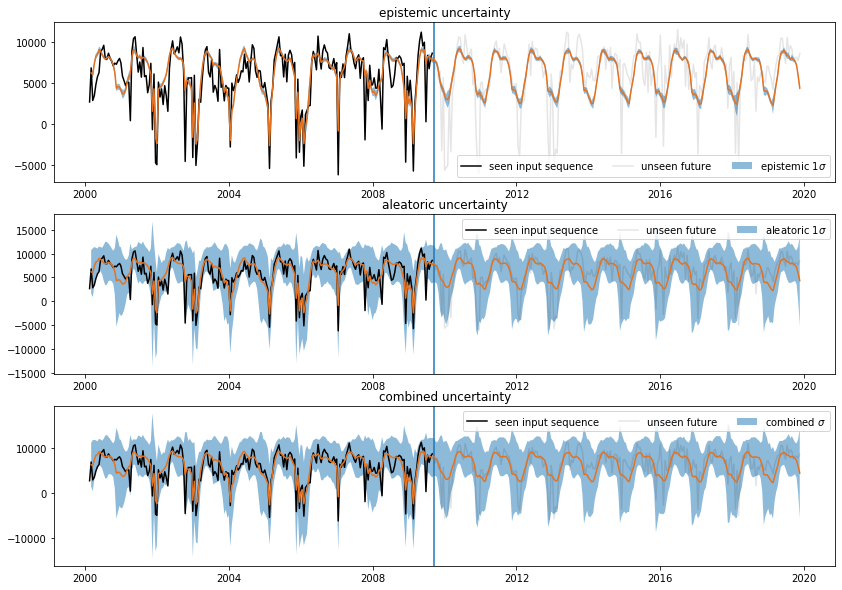

In [4]:
normalize_sigma_factor=0.5

model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(normalize_sigma_factor)

model = train(epochs, model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer)
    
x = testdataset.data[idx].astype(float)
date = testdataset.date[idx].astype(np.datetime64)
make_and_plot_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(testdataset.mean,testdataset.std), store=None)